# P5 - 03 - Maintenance Notebook

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functions import *

sns.set_theme(style="whitegrid")

# 1. Defining functions

The idea of our functions is to use the Adjusted Random Index scoring, to compare two groups of
clusters. Our two groups are :
1. The predicted clusters of our full dataset, based on a **full-dataset training**
2. The predicted clusters of our full dataset, based on a **partial dataset training**

We call a **partial dataset** our full dataset, from which we remove the most recent orders. It
will update many customers features (recency, total amount, total reviews, ...) and it's a way to
 **simulate the evolution of our dataset in time**.

In [2]:
def calculate_ari_score(
    customers_all,
    customers_older,
    model,
    scaler=None,
    limit=60000
):
    """ Use the given customer dataset and return 2 customers dataset based on recency

    Args:
        :param customers_all: (DataFrame) the dataset containing all customers
        :param customers_older: (DataFrame) the dataset containing customers older than N days
        :param model: (model) the model to use for the clustering
        :param scaler: (scaler|None) the scaler to apply to the data
        :param limit: (int) keep the last X customers to avoid sklearn ARI issue with big datasets

    Returns:
        :return: (float) the ARI score between the two dataset clusters
    """
    # Cloning the model to have one model per dataset
    model_older = clone(model)

    # We sort the customers by recency and keep only the X first one
    # It can be used to avoid sklearn bug on ARI calculation on big datasets
    customers_all.sort_values(by='recency', ascending=True, inplace=True)
    customers_older.sort_values(by='recency', ascending=True, inplace=True)
    customers_all = customers_all.head(limit)
    customers_older = customers_older.head(limit)

    if scaler is not None:
        customers_all = scaler.fit_transform(customers_all)
        customers_older = scaler.fit_transform(customers_older)

    # Training the two models
    model.fit(customers_all)
    model_older.fit(customers_older)

    # Predicting the whole dataset before comparison
    labels_all = model.predict(customers_all)
    labels_older = model_older.predict(customers_all)

    ari_score = adjusted_rand_score(labels_all, labels_older)

    return ari_score

In [3]:
def get_ari_evolution(model, months, features, data_folder_path='./data/'):
    """ Plot the evolution of ARI score using the given model and month

    Args:
        :param model: the clustering model to use
        :param months: (list) a list of month for ARI calculation
        :param features: the list of features to keep for the model
        :param data_folder_path: (string) the path to the dataset CSV

    Returns:
        :return: (list) the calculated ARI scores among given months
    """
    # We retrieve the whole dataset
    customers_all = create_enriched_customer_dataset(data_folder_path)
    customers_all.dropna(how='any', inplace=True)

    ari_scores = []
    for month in months:
        # We use the whole dataset to find the max date and retrieve the 2nd dataset
        recency = int(month * 30)
        end = datetime(
            customers_all['last_order_date'].max().year,
            customers_all['last_order_date'].max().month,
            customers_all['last_order_date'].max().day
        ) - timedelta(days=recency)
        customers_older = create_enriched_customer_dataset(data_folder_path, end=end)
        customers_older.dropna(how='any', inplace=True)

        score = calculate_ari_score(
            customers_all[features].copy(deep=True),
            customers_older[features].copy(deep=True),
            model=model,
            scaler=StandardScaler()
        )
        ari_scores.append(score)

    return ari_scores

# 2. Checking model stability

In [4]:
final_features = ['recency', 'total_orders', 'total_spent_amount']
kmean = KMeans(n_clusters=5, random_state=40)
ari_scores = get_ari_evolution(kmean, np.arange(10), features=final_features)

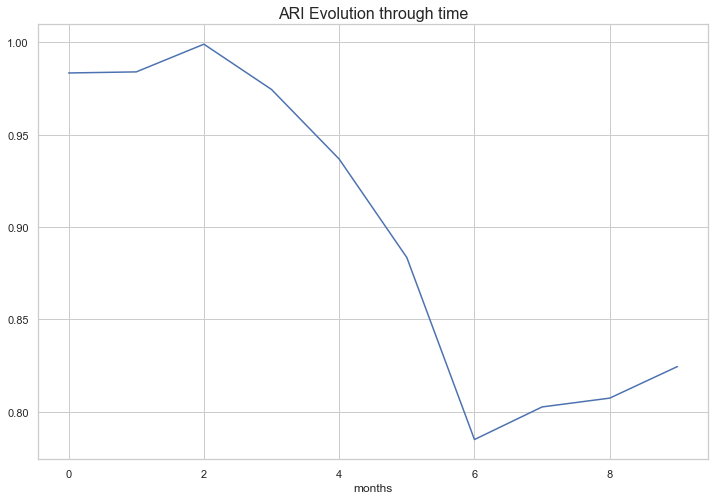

In [5]:
plt.figure(figsize=(12, 8))
plt.title("ARI Evolution through time", fontsize=16)
plt.xlabel('months')
plt.plot(np.arange(10), ari_scores)
plt.show()

# 3. Conclusion

We notice that the ARI decreases a lot after **3 or 4 month**. So we can decide to check de model
 after 4 month and update it immediately or after 6 months according to Olist expectations.